<a href="https://colab.research.google.com/github/rodsei/data-science-ifes/blob/main/cida_task_naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador de Texto com Naive Bayes

Referência: https://www.kaggle.com/barishasdemir/classification-with-naive-bayes

Para este notebook vamos utilizar uma base de dados composta por mensagens de texto SMS rotuladas como *ham* ou *spam*, publicada originalmente [aqui](https://github.com/Bhasfe/ml-algorithms/tree/master/Naive%20Bayes).

In [11]:
import pandas as pd

data = pd.read_csv("data.csv")
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Naive Bayes

Primeiramente precisamos entender como funciona o classificador Naive Bayes, que normalmente é utilizado para processamento de linguagem natural (NLP), assim como o contexto de filtros de spam, que vamos lidar aqui, análise de sentimwntos, classificação e recomendação.

A base do classificador é o Teorema de Bayes, cuja formula é exibida abaixo.

$P(A|B) = \large\frac{P(B|A)*P(A)}{P(B)}$

No Teorema temos:
- P(A|B) = probabilidade de A se B acontecer
- P(B|A) = probabilidade de B se A acontecer
- P(A) = probabilidade de A
- P(B) = probabilidade de B

Esses eventos são calculados de acordo com a probabilidade de acontecerem de acordo com os demais ecentos. Para maiores detalhes sobre o conceito, [aqui](https://www.kaggle.com/prashant111/naive-bayes-classifier-tutorial) estão maiores informações. Neste notebook vamos nos aprofundar na aplicação prática do classificador com o scikit-learn, que possui três implementações distintas:

- **Gaussian Naive Bayes**: trabalha com atributos contínuos, assumindo que os dados estão distribuídos conforme uma distribuição gaussiana.
- **Multinomial Naivel Bayes**: trabalha com atributos de frequências, como classificação de texto por exemplo
- **Bernoulli Naive Bayes**: trabalha com variáveis binárias polinomiais, também pode ser utilizado para classificação de texto.


## Processamento de linguagem Natural (NLP - *Natural Language Processing*)

Como o nosso problema de exemplo será uma atividade de classificação de texto, vamos utilizar o ***Multinomial Naive Bayes***. Além de conhecer o modelo do classificador, é importante conhecer também alguns conceitos relacionads à classificação de texto. Por se tratar de conceitos, vou manter os nomes originais em inglês para evitar quaisquer desvios de entendimento de cada um: 

1. Lemmatization ou Stemming: agrupar palavras que fazem parte de um mesmo radical (*Stem*) para que o sentido central seja identificado, como por exemplo, correr, correu, corria, correndo podem ser agrudapas como correr;
2. Stop words: conjunto de palavras irrelevantes, como preposições, artigos ou outras que não façam parte do contexto;
3. Tokenization: extração da lista de palavras entre espaços e pontuações;
4. Bag of Words: é uma representação numérica de dados textuais que os algoritmos podem compreender;
5. Tf-idf (Term Frequency - Inverse Term Frequency): é um conceito estatístico para identificar a importância das palavras no texto;

Para a *tokenização*, será utilizada a biblioteca `nltk.word_tokenize` e para identificar a frequência dos termos, será utilizada a biblioteca `TfiffVectorizer` do `scikit-learn`, que calcula o peso de cada palavra e retorna uma matriz de frequência em cada documento.

## Configuração e dependências

Para seguir com o exemplo, vamos instalar e importar todas as bibliotecas que serão utilizadas a partir de agora.

Instalando os pacotes:

In [12]:
!pip install -U scikit-learn
!pip install wordcloud
!pip install --user -U nltk

Importando todas as dependências do exemplo:

In [45]:
# Fundamentals
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
# Import NLTK to use its functionalities on texts
#"""DO NOT forget to download followings if you do not have
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
#"""
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# We will visualize the messages with a word cloud
from wordcloud import WordCloud
# Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
# Import Tf-idf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Import the Label Encoder
from sklearn.preprocessing import LabelEncoder
# Import the train test split
from sklearn.model_selection import train_test_split
# To evaluate our model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# I will keep the resulting plots
%matplotlib inline
# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Conhecendo a base de dados

Como já vimos uma prévia da base no início, vamos visualizar mais características relacionadas à distribuição dos dados e verificar se existem dados nulos.

In [14]:
data.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### Análise exploratória e preparação dos dados

Com as características acima, já podemos iniciar nossa análise identificando a distribuição das categorias, para descobrir se os dados estão balanceados ou não.

ham     4825
spam     747
Name: Category, dtype: int64

ham     0.865937
spam    0.134063
Name: Category, dtype: float64



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


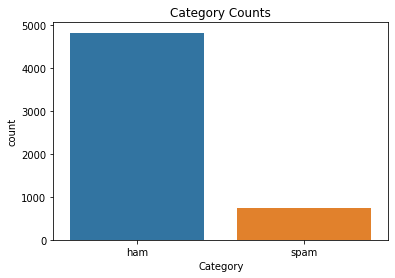

In [16]:
# Print the counts of each category
print(data['Category'].value_counts())
print()
# Print the proportions of each category
print(data['Category'].value_counts(normalize=True))
print()
# Visualize the Categories
sns.countplot(data['Category'])
plt.title("Category Counts")
plt.show()

Após verificar o desbalanceamento da base, precisamos transformar o rótulo em um dado numérico para deixar acessível ao modelo que vamos construir. Para isso, podemos usar o LabelEncoder que normalmente é utilizado para variáveis categóricas.

In [17]:
# Initialize the Label Encoder.
le = LabelEncoder()

# Encode the categories
data['Category_enc'] = le.fit_transform(data['Category'])

# Display the first five rows again to see the result
display(data.head())

# Print the datatypes
print(data.dtypes)

,Category,Message,Category_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


Category        object
Message         object
Category_enc     int64
dtype: object


Agora temos o nosso rótulo alvo representando *ham* como 0 e *spam* como 1. Com os rótulos adequados ao modelo, vamos continuar exporando os dados verificando a quantidade de palavras presentes as mensagens de cada categoria.


Category
ham     14.310259
spam    23.812584
Name: word_count, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


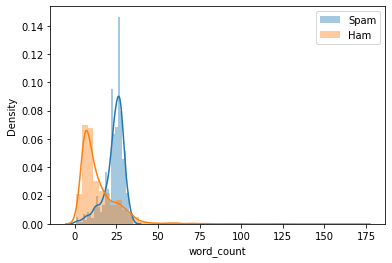

In [18]:
# Store the number of words in each messages
data['word_count'] = data['Message'].str.split().str.len()

# Print the average number of words in each category
print(data.groupby('Category')['word_count'].mean())

# Visualize the distribution of word counts in each category
sns.distplot(data[data['Category']=='spam']['word_count'], label='Spam')
sns.distplot(data[data['Category']=='ham']['word_count'], label='Ham'),
plt.legend()
plt.show()

De acordo com o gráfico, pudemos ver que os *spams* normalmente possuem um maior número de palavras que uma mensagem relevabte. Neste caso, vamos verificar qual é a palavra mais comum em cada uma das categorias.

In [19]:
# Make the letters lower case and tokenize the words
tokenized_messages = data['Message'].str.lower().apply(word_tokenize)

# Print the tokens to see how it looks like
print(tokenized_messages)

0       [go, until, jurong, point, ,, crazy.., availab...
1                [ok, lar, ..., joking, wif, u, oni, ...]
2       [free, entry, in, 2, a, wkly, comp, to, win, f...
3       [u, dun, say, so, early, hor, ..., u, c, alrea...
4       [nah, i, do, n't, think, he, goes, to, usf, ,,...
                              ...                        
5567    [this, is, the, 2nd, time, we, have, tried, 2,...
5568      [will, ü, b, going, to, esplanade, fr, home, ?]
5569    [pity, ,, *, was, in, mood, for, that, ., so, ...
5570    [the, guy, did, some, bitching, but, i, acted,...
5571                  [rofl, ., its, true, to, its, name]
Name: Message, Length: 5572, dtype: object


No texto, como podemos ver que existem várias palavras irrelevantes vamos como caracteres alfanuméricos e algumas *stop words*, que são palavras de junção ou complementares à ideia central na estrutura do texto. Vamos começar removendo os caracteres alfanuméricos.

In [20]:
# Define a function to returns only alphanumeric tokens
def alpha(tokens):
    """This function removes all non-alphanumeric characters"""
    alpha = []
    for token in tokens:
        if str.isalpha(token) or token in ['n\'t','won\'t']:
            if token=='n\'t':
                alpha.append('not')
                continue
            elif token == 'won\'t':
                alpha.append('wont')
                continue
            alpha.append(token)
    return alpha

# Apply our function to tokens
tokenized_messages = tokenized_messages.apply(alpha)

print(tokenized_messages)

0       [go, until, jurong, point, available, only, in...
1                          [ok, lar, joking, wif, u, oni]
2       [free, entry, in, a, wkly, comp, to, win, fa, ...
3       [u, dun, say, so, early, hor, u, c, already, t...
4       [nah, i, do, not, think, he, goes, to, usf, he...
                              ...                        
5567    [this, is, the, time, we, have, tried, contact...
5568         [will, ü, b, going, to, esplanade, fr, home]
5569    [pity, was, in, mood, for, that, so, any, othe...
5570    [the, guy, did, some, bitching, but, i, acted,...
5571                     [rofl, its, true, to, its, name]
Name: Message, Length: 5572, dtype: object


Sem os caracteres alfanuméricos, vamos remover as *stop words*.

In [21]:
# Define a function to remove stop words
def remove_stop_words(tokens):
    """This function removes all stop words in terms of nltk stopwords"""
    no_stop = []
    for token in tokens:
        if token not in stopwords.words('english'):
            no_stop.append(token)
    return no_stop

# Apply our function to tokens
tokenized_messages = tokenized_messages.apply(remove_stop_words)

print(tokenized_messages)

0       [go, jurong, point, available, bugis, n, great...
1                          [ok, lar, joking, wif, u, oni]
2       [free, entry, wkly, comp, win, fa, cup, final,...
3           [u, dun, say, early, hor, u, c, already, say]
4          [nah, think, goes, usf, lives, around, though]
                              ...                        
5567    [time, tried, contact, u, pound, prize, claim,...
5568                   [ü, b, going, esplanade, fr, home]
5569                            [pity, mood, suggestions]
5570    [guy, bitching, acted, like, interested, buyin...
5571                                   [rofl, true, name]
Name: Message, Length: 5572, dtype: object


Após a conclusão da etapa anterior, já podemos agrupar palavras que possuem um mesmo radical com uma lista de palavras que são relevantes para nossa base.

In [22]:
# Define a function to lemmatization
def lemmatize(tokens):
    """This function lemmatize the messages"""
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    # Create the lemmatized list
    lemmatized = []
    for token in tokens:
            # Lemmatize and append
            lemmatized.append(lemmatizer.lemmatize(token))
    return " ".join(lemmatized)

# Apply our function to tokens
tokenized_messages = tokenized_messages.apply(lemmatize)

print(tokenized_messages)

0       go jurong point available bugis n great world ...
1                                 ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts may...
3                     u dun say early hor u c already say
4                     nah think go usf life around though
                              ...                        
5567    time tried contact u pound prize claim easy ca...
5568                          ü b going esplanade fr home
5569                                 pity mood suggestion
5570    guy bitching acted like interested buying some...
5571                                       rofl true name
Name: Message, Length: 5572, dtype: object


Após todos esses processos, podemos atualizar a coluna da base de dados original de acordo com o valores tratados.

In [23]:
# Replace the columns with tokenized messages
data['Message'] = tokenized_messages

# Display the first five rows
display(data.head())

,Category,Message,Category_enc,word_count
0,ham,go jurong point available bugis n great world ...,0,20
1,ham,ok lar joking wif u oni,0,6
2,spam,free entry wkly comp win fa cup final tkts may...,1,28
3,ham,u dun say early hor u c already say,0,11
4,ham,nah think go usf life around though,0,13


Com a base finalizada, podemos criar visualizações mais claras e sem os valores que iriam poluir o sentido dessas visualizações. Para comparar as duas categorias, vamos montar uma nuvem de palavras para visualizar quais palavras são mais usadas em cada uma delas. Primeiramente vamos preparar uma função para construir a nuvem de palavaras.

In [26]:
def plot_word_cloud(category):
  # Get category messages
  msg_data = data[data['Category']==category]['Message'].str.cat(sep=', ')

  # Initialize the word cloud
  wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color ='white')

  # Generate the world clouds for each type of message
  category_wc = wc.generate(msg_data)

  # plot the world cloud for spam                     
  plt.figure(figsize = (5, 5), facecolor = None) 
  plt.imshow(category_wc) 
  plt.axis("off") 
  plt.title(f"Common words in {category} messages")
  plt.tight_layout(pad = 0) 
  plt.show() 

Agora já podemos visualizar os dados de cada categoria:

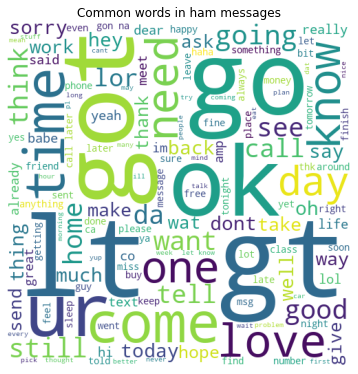

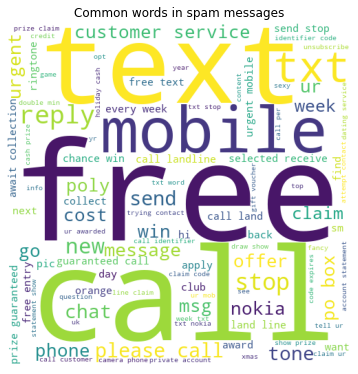

In [28]:
plot_word_cloud('ham')
print()
plot_word_cloud('spam')

Comparando as duas nuvems, podemos notar que as mensagens reais possuem muitas abreviações e são mensanges informais, de pessoas para pessoas, e as mensagens de spam possuem palavras como *free*, *mobile*, *cole* e *text*.

## Construindo o modelo

Os primeiros passos para a construção do modelo são a definição das características e do nosso nosso alvo e a preparação das bases de treino e teste.

In [30]:
X = data['Message']
y = data['Category_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, 
                                                    stratify=y)

Como a base de dados original está desbalanceada, precisamos utilizar o parâmetro ***stratify*** na separação das bases.

Com a base separada, vamos identificar as palavras mais importantes do documento descobrindo o índice ***tf-idf*** (*Term Frequency - inverse document frequency*) com a biblioteca TfidfVectorizer do scikit-learn. 

In [37]:
# Create the tf-idf vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii')

# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform(X_train)

# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)

Com o índice criado, já é possível construir o modelo, ustilizando a classe `MultinomialNB`

In [38]:
# Initialize the Multinomial Naive Bayes classifier
nb = MultinomialNB()

# Fit the model
nb.fit(tfidf_train, y_train)

# Print the accuracy score
print("Accuracy:",nb.score(tfidf_test, y_test))

Accuracy: 0.9587443946188341


A acurácia do treino aparentemente está boa por volta de 96%, mas somente essa métrica não é suficiente para afirmar que o desempenho do modelo de fato está bom. Para obter uma análise mais completa, vamos utilizar mais algumas métricas:

Confusion Matrix

[[966   0]
 [ 46 103]]


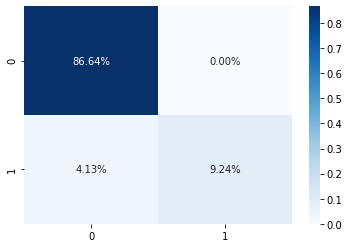



Classification Report

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       966
           1       1.00      0.69      0.82       149

    accuracy                           0.96      1115
   macro avg       0.98      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115



In [48]:
# Predict the labels
y_pred = nb.predict(tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.show()

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

Além disso, é importante ficar atento à *Area Under the ROC Curve*:


ROC AUC Score: 0.8456375838926175


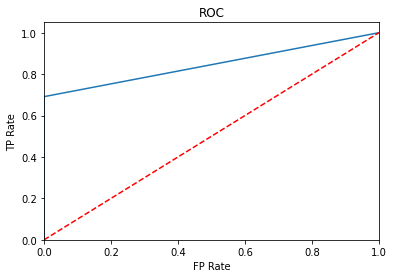

In [49]:
# Print the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:",auc_score)

# Get probabilities.
y_pred_proba = nb.predict(tfidf_test)

# Get False Positive rate, True Positive rate and the threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Visualize the ROC curve.
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC')
plt.show()

Apesar de apresentar um valor menor, ainda estamos com uma métrica boa analisando o gráfico. De acordo com a matriz de confusão e o relatório de classificação, o modelo está ótimo para detectar spam.

## Adaptando o modelo para português

Para se construir um classificador de processamento de linguagem natural em português, a primeira e maior alteração é uma fonte de dados escrita originalmente na língua portuguesa, apesar de óbvia, merece ser comentada pois apresentará características e formatos informais que não seriam passíveis de reprodução apenas realizando uma tradução da base.

Outras adaptações estão relacionadas às bibliotecas utilizadas durante o processo nas etapas de remoção das *stop words* e *lematização*.

Para as stopwords, o próprio NLTK possui uma base com a lista em português. Para utilizá-la, basta definir a linguagem:

In [51]:
pt_words = nltk.corpus.stopwords.words('portuguese')
pt_words[0:10]

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um']

Já o processo de agrupamento das palavras é mais complexo, pois a biblioteca disponibilizada no NLTK não é tão boa conforme podemos visualizar nos exemplos da [documentação oficial](http://www.nltk.org/howto/portuguese_en.html) na seção Stemming.  

```
stemmer = nltk.stem.RSLPStemmer()
stemmer.stem("copiar")
> 'copi'

stemmer.stem("paisagem")
> 'pais'
```

Existem outras opções disponíveis, como o [Stanza](https://stanfordnlp.github.io/stanza/index.html), que utiliza o método de validação CoNLL 2018, disponível [aqui](https://universaldependencies.org/conll18/evaluation.html), e apresenta os resultados obtidos pelo modelo no site oficial, conforme podemos obervar abaixo.

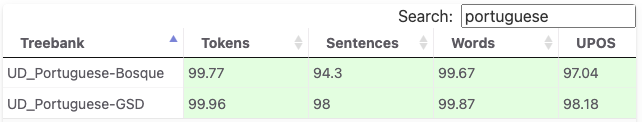

A CoNLL (Conference of Natural Language Learning) é uma conferência anual que estimula os participantes a criarem modelos linguísticos mais otimizados em uma competição. Consultando os participantes e ganhadores também podemos encontrar outras opções com diferentes contextos e complexidades.